## Experiment for mean non-convergence problem with Student's T target

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import torch
import math
import torch.distributions as dists
from scem import loss, util, kernel, net, stein, cpdkernel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import dirname, join
import ksdmom.sampler as samp
from collections import namedtuple

In [3]:
torch.manual_seed(101)
torch.set_default_tensor_type(torch.DoubleTensor)

In [4]:
results_path = './results/meanshift'
problem = 'StudentT'

In [5]:
dir_path = (join(results_path, problem))
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [6]:
font = {
    'family' : 'serif',
#     'weight' : 'bold',
    'size'   : 24
}
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', **font)
plt.rc('lines', linewidth=3, markersize=10)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [7]:
n = 1000
rep = 1
n_ps = 100
d = 5
m = torch.zeros(d)
df = 6
target = samp.IsotropicMultivariateStudentT(df, mean=m)

### Defining kernels

In [8]:
kimq  = kernel.KIMQ(b=-0.5)
loc = None
klin = kernel.KLinear(scale=1, loc=loc, bias=1)
w = kernel.MultiquadraticWeight(p=-0.5, bias=1, loc=loc)
kw = kernel.KSTWeight(w_func=w)
ktilted_lin = kernel.KSTProduct(klin, kw)
ksum_imq = kernel.KSTSumKernel([ktilted_lin, kimq])

w_ = kernel.MultiquadraticWeight(p=(1+1+0.1)/2, bias=1, loc=loc, scale=1./df**0.5)
kw_ = kernel.KSTWeight(w_func=w_)
k_lin_grwth = kernel.KSTProduct(ksum_imq, kw_)

w_ = kernel.MultiquadraticWeight(p=(2+1+0.1)/2, bias=1, loc=loc, scale=1./df**0.5)
kw_ = kernel.KSTWeight(w_func=w_)
k_quad_grwth = kernel.KSTProduct(ksum_imq, kw_)


kernels = {
    'IMQ': kimq, 
    'IMQ-sum-lin': k_lin_grwth,
    # 'IMQ-sum-quad': k_quad_grwth,
}


In [9]:
Format = namedtuple('Format', ['color', 'linestyle', 'marker'])
label_format_tuples = {
    'IMQ': ("IMQ ", Format('C1', '-', '*')),
    'IMQ-sum-lin': ('IMQ sum (lin.) ', Format('C3', '--', 'o')),
    'IMQ-sum-quad': ('IMQ sum (quad.)', Format('C5', '-.', 'v')),
}

### Compute KSD

In [10]:
rerun = False
vstat = True
ptbs = torch.logspace(0, 3, n_ps)
data = np.empty([len(kernels), rep, n_ps])
losses = {
    k: loss.KSD(v, target.score) 
    for k, v in kernels.items()
}
for l_i, (key, l) in enumerate(losses.items()):
    filename = (
        '{}.npy'.format(key) if not vstat else
        '{}_vstat.npy'.format(key)
    )
    path = os.path.join(dir_path, filename)
    print(path)
    if os.path.exists(path) and not rerun:
        tmp = np.load(path)
        data[l_i] = tmp
    else:
        for j, p in enumerate(ptbs):
            X1 = target.sample(n//2)
            mean = (p+1) * torch.ones(d) / d**0.5
            X2 = torch.randn(n//2, d) + mean 
            prob = torch.ones(1) / (p+1)
            weight = torch.ones(n)
            weight[:n//2] = torch.ones(1) - prob
            weight[n//2:] = prob
            weight = torch.tensor([1-prob]*(n//2) + [prob]*(n//2))/(n//2)
            X = torch.vstack([X1, X2])
            for i in range(rep):
                data[l_i, i, j] = l.loss(X, vstat=vstat, weight=weight, ignore_diag=False).detach().numpy()
        result = data[l_i]
        np.save(path, result)    
ps = ptbs.detach().numpy()

./results/meanshift/StudentT/IMQ_vstat.npy
./results/meanshift/StudentT/IMQ-sum-lin_vstat.npy


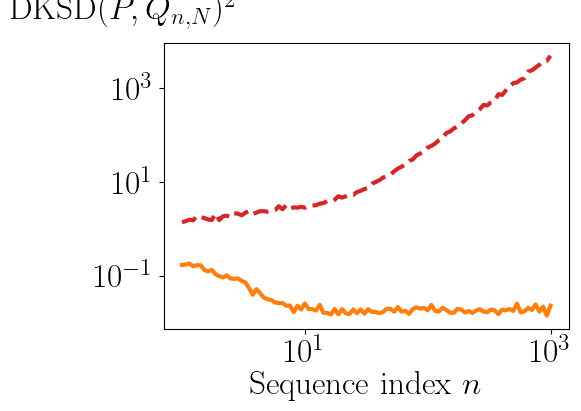

In [15]:
from matplotlib.ticker import LogLocator
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')


label = ax.set_xlabel('Sequence index $n$', fontsize = 24)
label = ax.set_ylabel('$\\mathrm{DKSD}(P, Q_{n,N})^2$', fontsize = 24)
label.set_rotation(0)
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.1, 1.05)    

ax.set_yticks([1e+0, 1e+1, 1e+2])

ps = ptbs.detach().numpy()
for ki, key in enumerate(losses.keys()):
    label = label_format_tuples[key][0]
    fmt = label_format_tuples[key][1]
    y = data[ki].mean(axis=0)
    ax.plot(ps, data[ki].mean(axis=0), label=label, 
            color=fmt.color, linestyle=fmt.linestyle)
#     error_low = (y - np.percentile(data[ki], q=5, axis=0))
#     error_high = np.percentile(data[ki], q=95, axis=0)-y
#     errors = np.vstack([error_low, error_high])
#     ax.errorbar(ps, y, yerr=errors,
#             color=fmt.color, label=label, linestyle=fmt.linestyle)
# ax.legend(bbox_to_anchor=(1.75,1.), ncol=4)
# plt.legend(bbox_to_anchor=(1.75,1.), ncol=4)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.yaxis.set_minor_locator(LogLocator(numticks=10))
 
# plt.savefig('ksd_comparison_tdist_mean_shift.pdf', bbox_inches='tight')
plt.savefig('ksd_comparison_tdist_mean_shift_vstat_df{}.pdf'.format(df), bbox_inches='tight')

# plt.savefig('ksd_comparison_tdist_mean_shift_legend.pdf', bbox_inches='tight')

### Varying sample size 

In [12]:
rerun = False
n_ps_sample = 30
sample_sizes = torch.logspace(2, 4, n_ps_sample)
sample_sizes = torch.floor(sample_sizes/2)

data = np.empty([len(kernels), rep, n_ps_sample])
losses = {
    k: loss.KSD(v, target.score) 
    for k, v in kernels.items()
}
p = 1e+3
prob = torch.ones(1) / p
mean = p * torch.ones(d) / d**0.5
for l_i, (key, l) in enumerate(losses.items()):
    filename = (
        '{}_sampinc.npy'.format(key) if not vstat else
        '{}_sampinc_vstat.npy'.format(key)
    )
    path = os.path.join(dir_path, filename)
    if os.path.exists(path) and not rerun:
        tmp = np.load(path)
        data[l_i] = tmp[:rep]
    else:
        for j, n in enumerate(sample_sizes):
            print(n)
            n = int(n.item())
            X1 = target.sample(n)
            X2 = torch.randn(n, d) + mean 
            prob = torch.ones(1) / (p+1)
            weight = torch.ones(n)
            weight = torch.tensor([1-prob]*(n) + [prob]*(n))/(n)
            X = torch.vstack([X1, X2])
            for i in range(rep):
                data[l_i, i, j] = l.loss(X, vstat=vstat, weight=weight,ignore_diag=False).detach().numpy()
        result = data[l_i]
        np.save(path, result)               

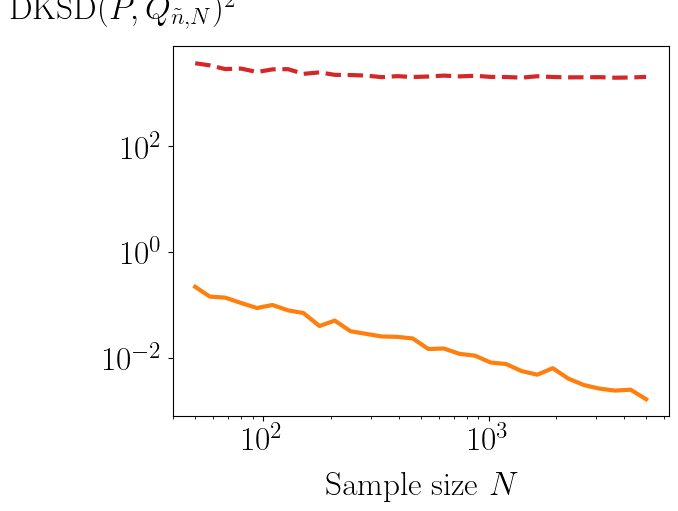

In [16]:
from matplotlib.ticker import LogLocator
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')


label = ax.set_xlabel('Sample size $N$', fontsize = 24)
label = ax.set_ylabel('$\\mathrm{DKSD}(P, Q_{\\tilde{n}, N})^2$', fontsize = 24)
label.set_rotation(0)
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.1, 1.05)    

# ax.set_yticks([1e+0, 1e+1, 1e+2])

ps = sample_sizes.detach().numpy()
for ki, key in enumerate(losses.keys()):
    label = label_format_tuples[key][0]
    fmt = label_format_tuples[key][1]
    y = data[ki].mean(axis=0)
    ax.plot(ps, y, label=label, 
        color=fmt.color, linestyle=fmt.linestyle)

# ax.legend(bbox_to_anchor=(1.75,1.), ncol=4)
ax.set_yscale('log')
ax.set_xscale('log')

#ax.yaxis.set_minor_locator(LogLocator(numticks=10))
 
plt.savefig('ksd_comparison_tdist_mean_shift_sampsize_vstat_df{}.pdf'.format(df), bbox_inches='tight')
